In [1]:
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Using whitebox for DEM preprocessing and basin delineation
from whitebox_workflows import WbEnvironment
wbe = WbEnvironment()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

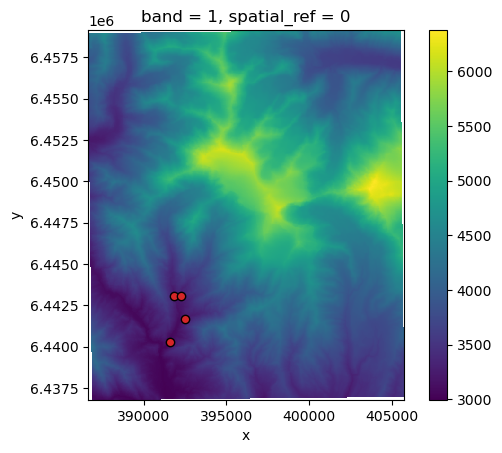

In [2]:
# Quicklook of the elevation dataset and outlet points
outlet_points = gpd.read_file(r'data\outlet_points.shp')
dem = rxr.open_rasterio(r'data\ESA_COP30_UTM19S.tif', masked=True).squeeze()

fig, ax = plt.subplots()
dem.plot.imshow(ax=ax)
outlet_points.plot(ax=ax, color='tab:red', ec='k')

In [3]:
# Open dem with whitebox and preprocess

wdem = wbe.read_raster(r'data\ESA_COP30_UTM19S.tif')
wdem_nosink = wbe.fill_depressions(wdem)
fdir = wbe.d8_pointer(wdem_nosink)
facc = wbe.d8_flow_accum(fdir, input_is_pointer=True, out_type='catchment area')

streams_r = wbe.extract_streams(facc, threshold=1e6)
streams_v = wbe.raster_streams_to_vector(streams_r, fdir)
rnetwork = wbe.vector_stream_network_analysis(streams_v, wdem)

wbe.write_raster(fdir, r'data\flow_directions_d8.tif')
wbe.write_raster(facc, r'data\flow_accumulation_d8.tif')
wbe.write_vector(rnetwork[0], r'data\streams.shp')

In [4]:
# Snap pour points to DEM river network
woutlets = wbe.read_vector(r'data\outlet_points.shp')
snapped = wbe.snap_pour_points(woutlets, facc, snap_dist=250)
wbe.write_vector(snapped, r'data\outlet_points_snapped.shp')

In [5]:
# Delineate basins
outlet_points_snapped = gpd.read_file(r'data\outlet_points_snapped.shp')
for fid, name in zip(outlet_points_snapped.index, outlet_points['Names']):
    shp = gpd.GeoSeries(outlet_points_snapped.loc[fid].geometry)
    shp = gpd.GeoDataFrame(geometry=shp.geometry,
                           crs=outlet_points_snapped.crs)
    shp.to_file(r'tmp\tmp.shp')
    
    shp_wbe = wbe.read_vector(r'tmp\tmp.shp')
    basin = wbe.watershed(fdir, shp_wbe)
    wbe.write_vector(wbe.raster_to_vector_polygons(basin), 
                     rf'data\basins\Basin_{name}.shp')

In [6]:
# Load basins and fill attribute table with pouring points attributes
basins = [gpd.read_file(rf'data\basins\Basin_{name}.shp')
          for name in outlet_points['Names']]
basins = pd.concat(basins, axis=0).reset_index(drop=True)
basins['outlet_x'] = outlet_points['outlet_x'].values
basins['outlet_y'] = outlet_points['outlet_y'].values
basins['Names'] = outlet_points['Names'].values
basins.to_file(r'data\Basins.shp')
basins

,FID,VALUE,geometry,outlet_x,outlet_y,Names
0,1,1.0,"POLYGON ((394629.013 6451922.437, 394800.585 6...",391596.082,6440253.040,B0
1,1,1.0,"POLYGON ((394629.013 6451922.437, 394800.585 6...",391823.499,6443027.518,B1
2,1,1.0,"POLYGON ((395744.229 6451607.889, 395972.991 6...",392278.331,6443042.679,B2
3,1,1.0,"POLYGON ((398060.447 6448004.884, 398089.042 6...",392490.586,6441678.181,B3


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

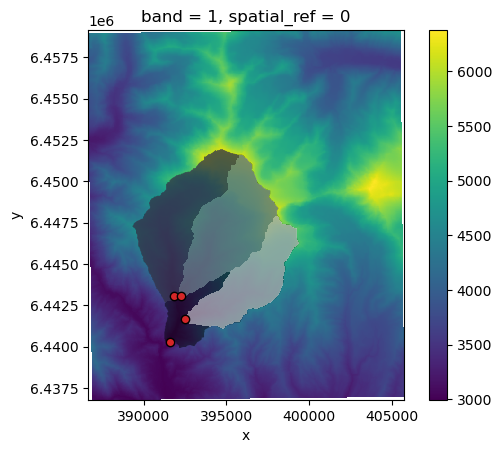

In [7]:
# Check delineated basins
fig, ax = plt.subplots()
dem.plot.imshow(ax=ax)
basins.plot(ax=ax, column='Names', alpha=0.5, cmap='bone')
outlet_points.plot(ax=ax, color='tab:red', ec='k')

In [11]:
import os
import glob
for f in glob.glob(r'tmp\*'):
    os.remove(f)